## 策略编写与参数设置

参数与变量的区别: 参数用来传递，变量是随着过程的赋值改变的

ArrayManager: 生成数组插入与管理数据对象

## 回测引擎修改内容
1. symbolList: 支持多品种以列表格式输入引擎
2. posDict: 可记录多个品种的多空情况

---
## CtaTemplate 内的方法

3. self.cancelAll(): 取消所有订单
4. ArrayManger(size): 数组管理器

In [9]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = 'ChannelCMT'
    
    # 策略参数
    barPeriod = 200
    fastWindow = 60     # 快速均线参数
    slowWindow = 120     # 慢速均线参数
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['barPeriod']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        
        # 生成Bar数组
        self.setArrayManagerSize(self.barPeriod)
#         self.fastMa0 = {s: 0 for s in self.symbolList}   # 当前最新的快速EMA
#         self.fastMa1 = {s: 0 for s in self.symbolList}   # 上一根的快速EMA
#         self.slowMa0 = {s: 0 for s in self.symbolList}   # 当前最新的慢速EMA
#         self.slowMa1 = {s: 0 for s in self.symbolList}   # 上一根的慢速EMA


        self.mail("chushihuaaaaaaaaaaaaaaaaaaaaaaaaa")
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "1m")

        if not am.inited:
            return

        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am.close, self.fastWindow)        
        slowMa = ta.EMA(am.close, self.slowWindow)

        crossOver = fastMa[-1]>slowMa[-1] and fastMa[-2]<=slowMa[-2]     # 金叉上穿
        crossBelow = fastMa[-1]<slowMa[-1] and fastMa[-2]>=slowMa[-2]   # 死叉下穿
        print('crossOver:',crossOver)
        print('crossBelow:',crossBelow)

        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥
        if crossOver:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, 1)
                self.buy(symbol,bar.close*1.02, 1)

        # 死叉和金叉相反
        elif crossBelow :
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, 1)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, 1)
                self.short(symbol,bar.close*0.98, 1)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(u'出现未知订单，需要策略师外部干预,ID:%s, symbol:%s,direction:%s,offset:%s'% (order.vtOrderID, order.vtSymbol, order.direction, order.offset))
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

## 配置引擎参数


仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function DoubleMaStrategy.onBar at 0x0000023AE949CD08>, <__main__.DoubleMaStrategy object at 0x0000023AF2F8E6A0>)
2018-11-12 12:34:48.540222	开始回测
2018-11-12 12:34:48.540222	策略初始化
2018-11-12 12:34:48.541221	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-12 12:34:49.644092	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 12:34:49.652084	载入完成，数据量：12000
2018-11-12 12:34:49.652084	策略初始化完成
2018-11-12 12:34:49.652084	策略启动完成
2018-11-12 12:34:49.652084	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-12 12:34:49.655081	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-12 12:34:53.524124	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-11-12 12:34:53.539109	载入完成，数据量：43230
2018-11-12 12:34:53.539109	当前回放数据:[20181001 12:00,20181031 16:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20181001120000
2018-11-12 12:34:53.542108	载入历史数据。数据范围:[20180930 05:51,20181003 12:01)

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cros

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False:59.122398	Progress: 18%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cros

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cros

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossB

crossOver: False:04.851538	Progress: 39%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow:

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False:05.481892	Progress: 41%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False:06.527823	Progress: 44%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossOver: False:06.828519	Progress: 45%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossOver: False:07.194141	Progress: 46%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossOver: False:07.517811	Progress: 47%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cros

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False:08.148166	Progress: 49%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False:08.728572	Progress: 51%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False:12.043183	Progress: 63%    
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow

crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: 

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: True
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cros

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cro

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: True
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
cros

crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
cr

D:\Anaconda3\lib\site-packages\vnpy\trader\app\ctaStrategy\ctaBacktesting.py:1287: RuntimeWarning: invalid value encountered in log
  df['return'] = (np.log(df['balance']) - np.log(df['balance'].shift(1))).fillna(0)



crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
crossOver: False
crossBelow: False
2018-11-12 12:35:22.038958	数据回放结束
2018-11-12 12:35:22.040955	策略日志已生成
2018-11-12 12:35:22.040955	计算按日统计结果
2018-11-12 12:35:22.061934	------------------------------
2018-11-12 12:35:22.061934	首个交易日：	2018-10-01 00:00:00
2018-11-12 12:35:22.061934	最后交易日：	2018-10-31 00:00:00
2018-11-12 12:35:22.061934	总交易日：	31
2018-11-12 12:35:22.061934	盈利交易日	6
2018-11-12 12:35:22.061934	亏损交易日：	25
2018-11-12 12:35:22.061934	起始资金：	100000
2018-11-12 12:35:22.061934	结束资金：	-38,585.84
2018-11-12 12:35:22.061934	总

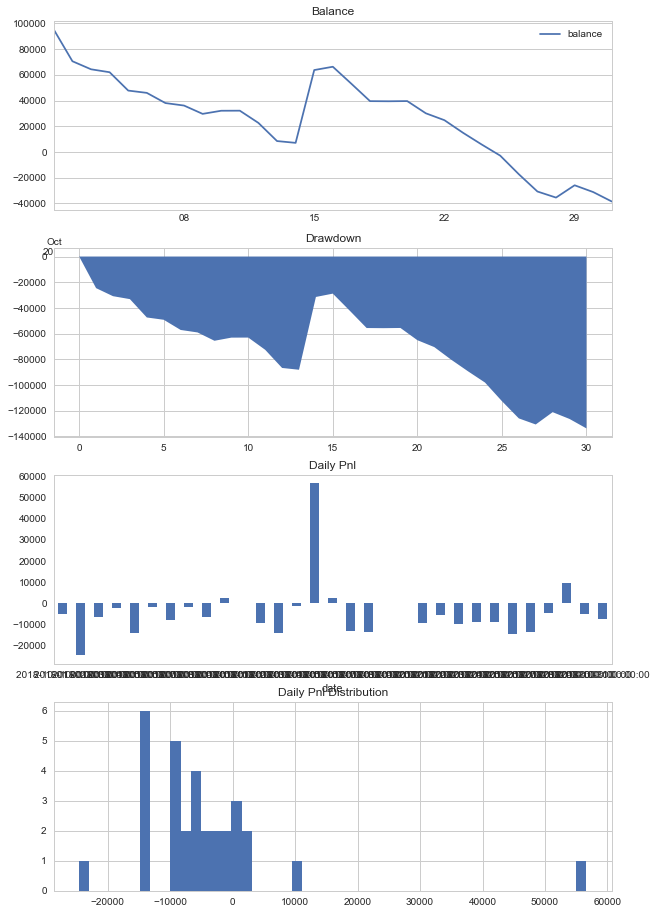

2018-11-12 12:35:23.892063	计算回测结果
2018-11-12 12:35:23.926028	交割单已生成
2018-11-12 12:35:23.926028	------------------------------
2018-11-12 12:35:23.926028	第一笔交易：	2018-10-01 16:59:00
2018-11-12 12:35:23.926028	最后一笔交易：	2018-10-31 15:58:00
2018-11-12 12:35:23.926028	总交易次数：	259
2018-11-12 12:35:23.926028	总盈亏：	-138,902.53
2018-11-12 12:35:23.927027	最大回撤: 	-138,902.53
2018-11-12 12:35:23.927027	平均每笔盈利：	-536.3
2018-11-12 12:35:23.927027	平均每笔滑点：	0.0
2018-11-12 12:35:23.927027	平均每笔佣金：	654.86
2018-11-12 12:35:23.927027	胜率		19.31%
2018-11-12 12:35:23.927027	盈利交易平均值	3,946.88
2018-11-12 12:35:23.927027	亏损交易平均值	-1,608.84
2018-11-12 12:35:23.927027	盈亏比：	2.45
2018-11-12 12:35:25.093833	策略回测统计图已保存


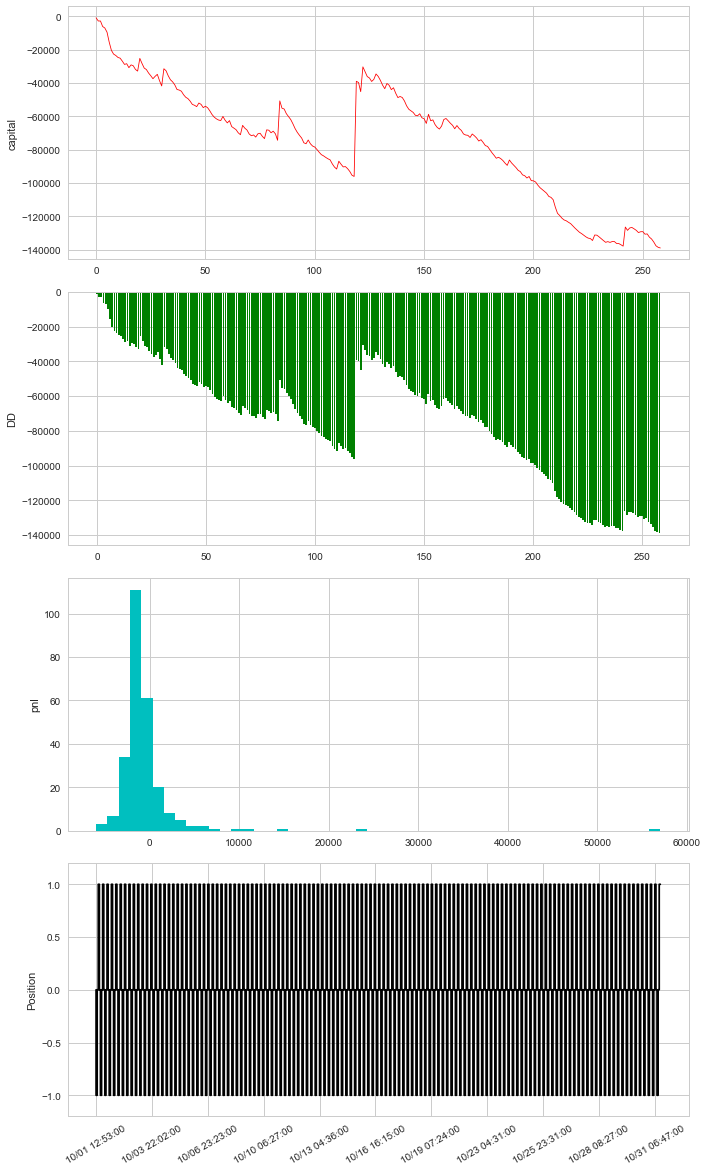

2018-11-12 12:35:25.664250	计算按日统计结果


D:\Anaconda3\lib\site-packages\vnpy\trader\app\ctaStrategy\ctaBacktesting.py:1287: RuntimeWarning: invalid value encountered in log
  df['return'] = (np.log(df['balance']) - np.log(df['balance'].shift(1))).fillna(0)


In [10]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(DoubleMaStrategy, {'symbolList': ['BTCUSDT:binance',
#                                                             'EOSUSDT:binance',
                                                            # 'ETHUSDT:binance'
#                                                             'eos_quarter:OKEX'
                                                            # 'tEOSUSD:bitfinex'
                                                            ]},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('DoubleMaStrategyReport.xlsx')

## 查看绩效回测绩效

In [12]:
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-10-01 12:53:00,空,,,0.0,,开仓,1,,6628.99,0.0,None,,,1,2018-10-01 12:53:00,1,1,BTCUSDT:binance,1
2018-10-01 16:59:00,多,,,0.0,,平仓,2,,6632.49,0.0,None,,,2,2018-10-01 16:59:00,1,2,BTCUSDT:binance,2
2018-10-01 16:59:00,多,,,0.0,,开仓,3,,6632.49,0.0,None,,,3,2018-10-01 16:59:00,1,3,BTCUSDT:binance,3
2018-10-01 17:36:00,空,,,0.0,,平仓,4,,6620.01,0.0,None,,,4,2018-10-01 17:36:00,1,4,BTCUSDT:binance,4
2018-10-01 17:36:00,空,,,0.0,,开仓,5,,6620.01,0.0,None,,,5,2018-10-01 17:36:00,1,5,BTCUSDT:binance,5
2018-10-01 21:04:00,多,,,0.0,,平仓,6,,6613.38,0.0,None,,,6,2018-10-01 21:04:00,1,6,BTCUSDT:binance,6
2018-10-01 21:04:00,多,,,0.0,,开仓,7,,6613.38,0.0,None,,,7,2018-10-01 21:04:00,1,7,BTCUSDT:binance,7
2018-10-01 21:34:00,空,,,0.0,,平仓,8,,6587.01,0.0,None,,,8,2018-10-01 21:34:00,1,8,BTCUSDT:binance,8
2018-10-01 21:34:00,空,,,0.0,,开仓,9,,6587.01,0.0,None,,,9,2018-10-01 21:34:00,1,9,BTCUSDT:binance,9
